In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
currentdir = os.path.dirname(os.path.realpath('__file__'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from datasets.lorenz import Lorenz63

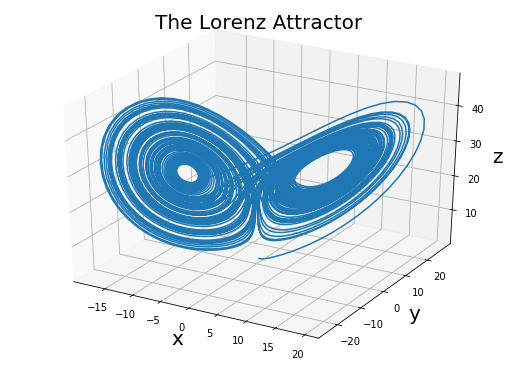

In [2]:
# Generate and plot Lorenz 63 model
tmax = 100
num_samples = 10000
dt = tmax/num_samples # 0.01
X0 = np.array([0, 1, 1.05]) # Initial condition

L63 = Lorenz63(tmax, X0, num_samples)
L63.plot()

In [3]:
def which_wing(X: np.array, lag: int) -> np.array:
    """ Returns array of 0s and 1s corresponding to whether a point on the attractor lands on the
        left or right wing respectively after time=lag
        Args:
            X: array of shape (num_samples, 3)
        
        Output: array of shape (num_samples - lag, )
    """
    x, y, z = X.transpose()
    return (x[lag:] > 0).astype(int)

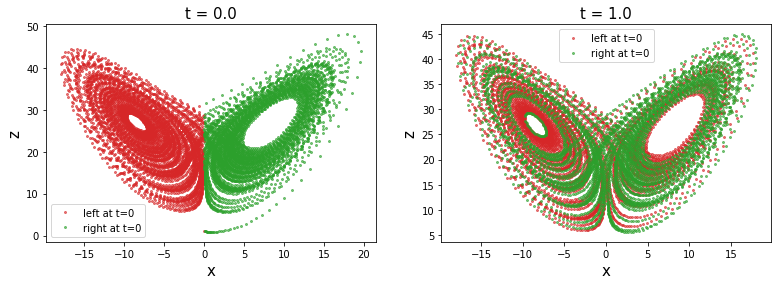

In [4]:
tfinal = 1.
tsteps = int(tfinal/dt)
X = L63.trajectory
N = L63.num_samples
initial_labels = which_wing(X,lag=0)[:N-tsteps]

left_indices = np.argwhere(initial_labels == 0)
right_indices = np.argwhere(initial_labels == 1)

initially_left_X_t0 = np.array([X[i] for i in left_indices]).squeeze()
initially_right_X_t0 = np.array([X[i] for i in right_indices]).squeeze()

initially_left_X_t100 = np.array([X[i + tsteps] for i in left_indices]).squeeze()
initially_right_X_t100 = np.array([X[i + tsteps] for i in right_indices]).squeeze()

initially_left_X = np.stack([initially_left_X_t0, initially_left_X_t100])
initially_right_X = np.stack([initially_right_X_t0, initially_right_X_t100])

# Plot
fig = plt.figure(figsize=(13, 4))
timestamps = [0, tsteps]
for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    left_x, left_z = initially_left_X[i][:,0], initially_left_X[i][:,2]
    right_x, right_z = initially_right_X[i][:,0], initially_right_X[i][:,2]
    plt.plot(left_x, left_z, 'o', color='tab:red', ms=2, alpha=0.6, label=f'left at t={0}')
    plt.plot(right_x, right_z, 'o', color='tab:green', ms=2, alpha=0.6, label=f'right at t={0}')
    ax.set_xlabel('x', fontsize=15)
    ax.set_ylabel('z', fontsize=15)
    ax.set_title(f't = {timestamps[i]*dt}', fontsize=15)
    ax.legend()

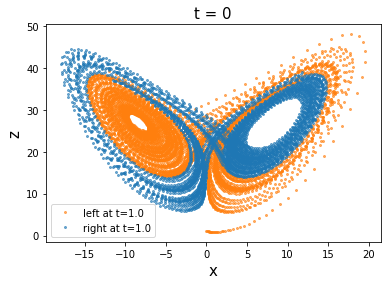

In [5]:
lag = tsteps
labels = which_wing(X,lag=lag)

left_indices = np.argwhere(labels == 0)
right_indices = np.argwhere(labels == 1)

eventually_left_X = np.array([X[i] for i in left_indices]).squeeze()
eventually_right_X = np.array([X[i] for i in right_indices]).squeeze()

# Plot
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
left_x, left_z = eventually_left_X[:,0], eventually_left_X[:,2]
right_x, right_z = eventually_right_X[:,0], eventually_right_X[:,2]
plt.plot(left_x, left_z, 'o', color='tab:orange', ms=2, alpha=0.6, label=f'left at t={tsteps*dt}')
plt.plot(right_x, right_z, 'o', color='tab:blue', ms=2, alpha=0.6, label=f'right at t={tsteps*dt}')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('z', fontsize=15)
ax.set_title(f't = 0', fontsize=15)
ax.legend()
plt.show()

## 1. Logistic Regression

In [6]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [7]:
X = X[:N-lag]
y = labels
train_X, test_X, train_y, test_y = train_test_split(X, labels, test_size=0.2)

In [8]:
model_lr = LogisticRegression()
model_lr.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

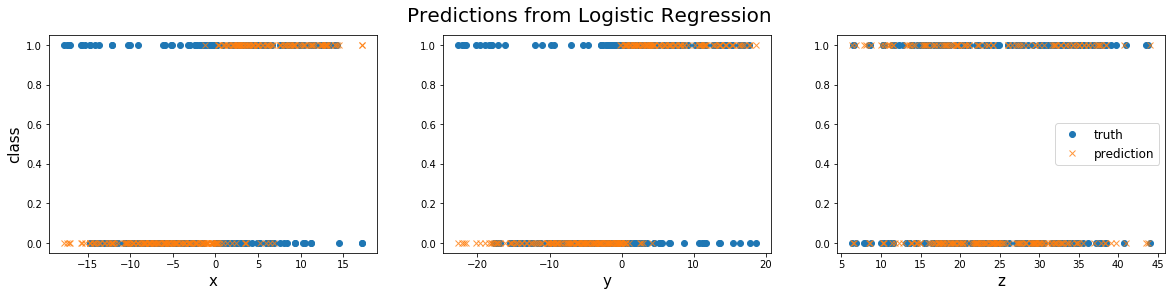

In [9]:
def plot_predictions(f, X, y, title):
    ypred = f(X)
    fig = plt.figure(figsize=(20, 4))
    coord = {0: 'x', 1: 'y', 2: 'z'}
    for i in range(3):
        ax = plt.subplot(1, 3, i+1)
        plt.plot(X[:250,i], y[:250], 'o', label='truth')
        plt.plot(X[:250,i], ypred[:250], 'x', alpha=0.8, label='prediction')
        ax.set_xlabel(coord[i], fontsize=15)
        if i==0:
            ax.set_ylabel('class', fontsize=15)
    ax.legend(fontsize=12)
    plt.suptitle(title, fontsize=20)
    plt.show()

plot_predictions(model_lr.predict, test_X, test_y, 'Predictions from Logistic Regression')

In [10]:
accuracy_lr = model_lr.score(test_X, test_y)
print("Accuracy of logistic regression: {:.4f}".format(accuracy_lr))

Accuracy of logistic regression: 0.6439


### Extending the feature space

In [11]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
transform = poly.fit_transform

model_lr_plus = LogisticRegression()
train_X_extended = transform(train_X)

model_lr_plus.fit(train_X_extended, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

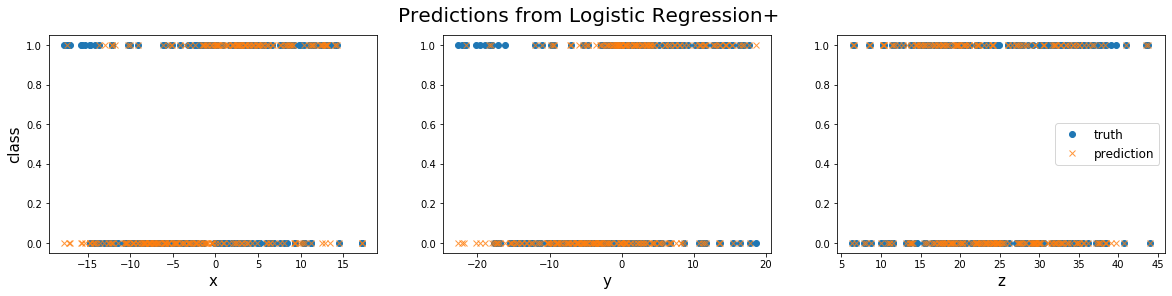

Accuracy of logistic regression with extra quadratic features: 0.7500


In [12]:
test_X_extended = transform(test_X)
accuracy_lr_ext = model_lr_plus.score(test_X_extended, test_y)
plot_predictions(model_lr_plus.predict, test_X_extended, test_y, 'Predictions from Logistic Regression+')
print("Accuracy of logistic regression with extra quadratic features: {:.4f}".format(accuracy_lr_ext))

Not bad!

## 2. Decision Trees

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

### 2.1. Selecting a decision tree

In [14]:
model_dt = DecisionTreeClassifier()
model_dt.fit(train_X, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

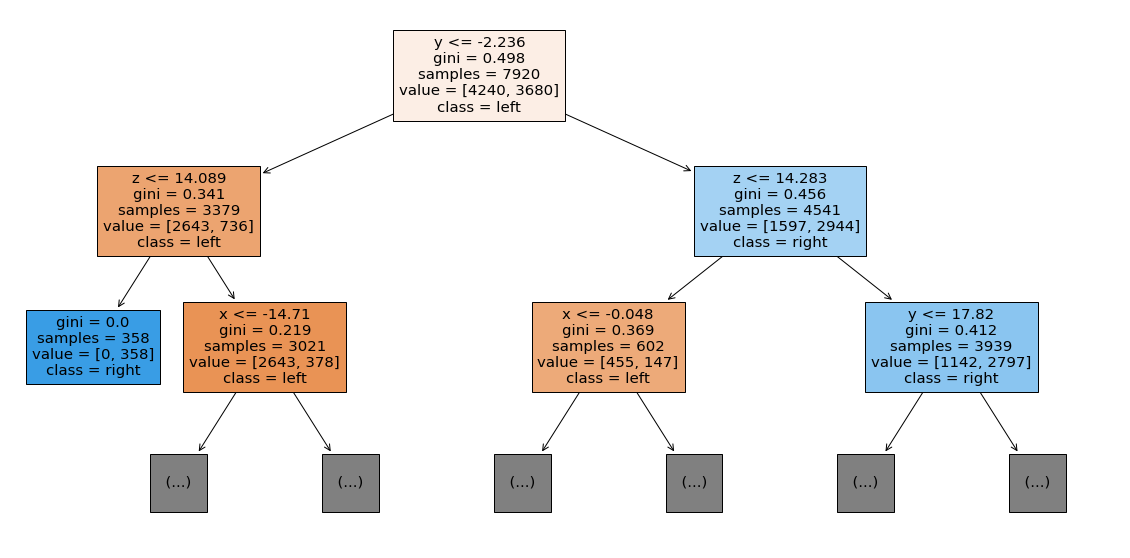

In [15]:
fig = plt.figure(figsize = (20, 10))
sklearn.tree.plot_tree(model_dt,
                       max_depth = 2,
                       feature_names = ['x', 'y', 'z'],
                       class_names = ['left', 'right'],
                       filled = True)
plt.show()

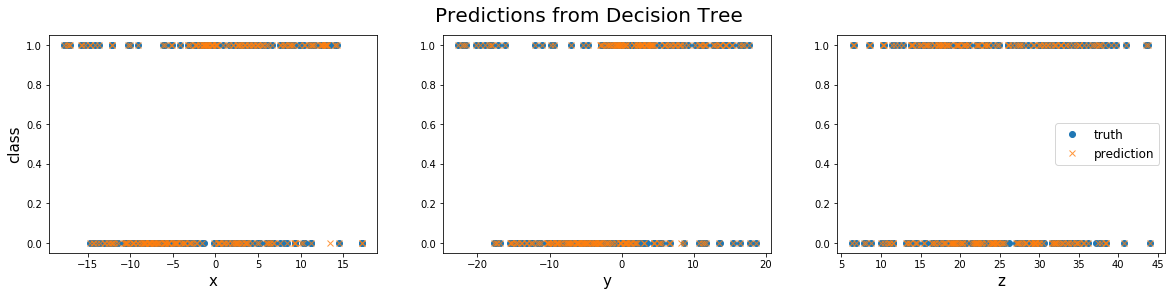

Accuracy of decision tree: 0.9611


In [16]:
accuracy_dt = model_dt.score(test_X, test_y)
plot_predictions(model_dt.predict, test_X, test_y, 'Predictions from Decision Tree')
print("Accuracy of decision tree: {:.4f}".format(accuracy_dt))

### 2.2. Random forests

In [17]:
model_rf = RandomForestClassifier(max_depth=15)
model_rf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

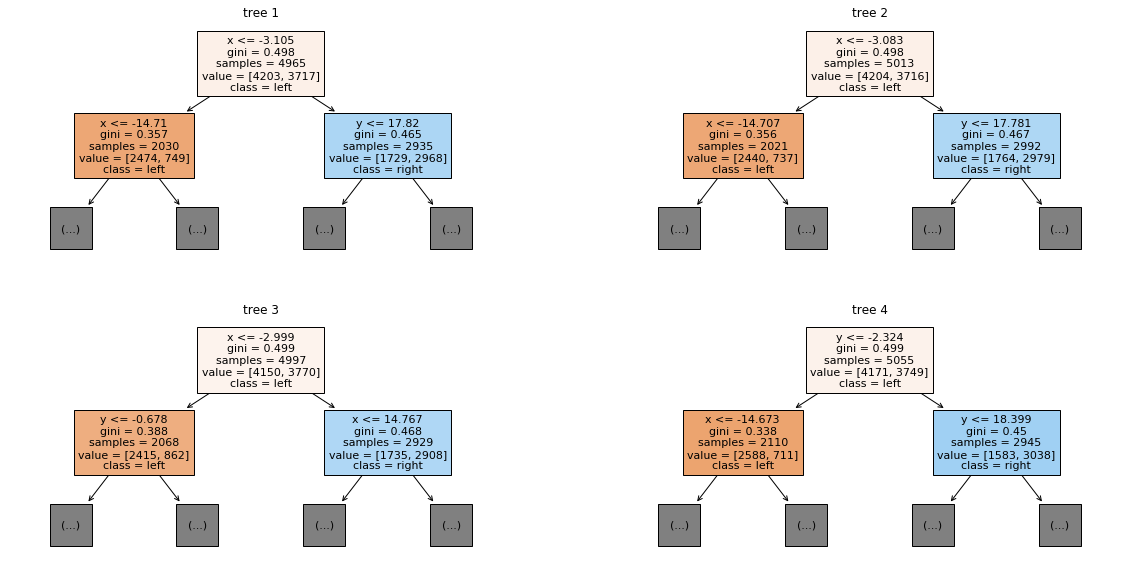

In [18]:
fig = plt.figure(figsize = (20, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    sklearn.tree.plot_tree(model_rf.estimators_[i],
                           max_depth = 1,
                           feature_names = ['x', 'y', 'z'],
                           class_names = ['left', 'right'],
                           filled = True)
    ax.set_title(f'tree {i+1}', fontsize=12)
plt.show()

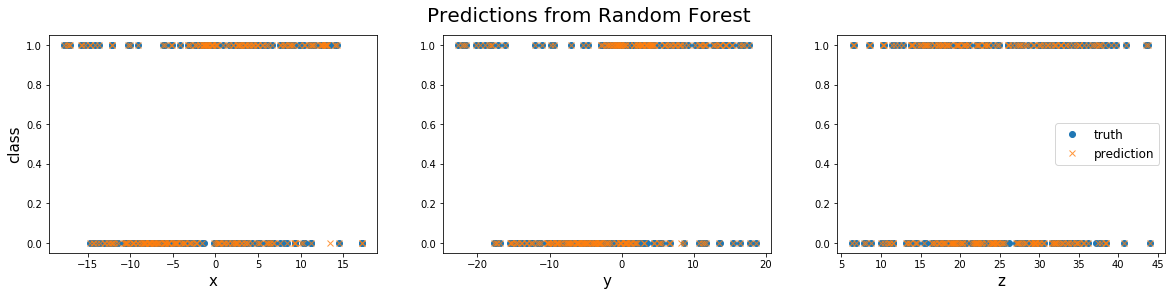

Accuracy of random forest: 0.9667


In [19]:
plot_predictions(model_rf.predict, test_X, test_y, 'Predictions from Random Forest')
accuracy_rf = model_rf.score(test_X, test_y)
print("Accuracy of random forest: {:.4f}".format(accuracy_rf))

## 3. Neural Networks

In [40]:
from tensorflow import keras
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization

### 3.1. Data pre-processing

First, we introduce a normalizing layer with respect to the training data. See [this article](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) for more details on why it is a good idea to normalize data.

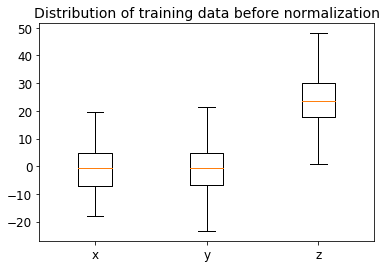

In [95]:
def box_plot(X: np.array, title: str):
    # X must have size (n_samples, 3)
    fig = plt.figure(figsize=(6, 4))
    ax = fig.gca()
    plt.boxplot(X, labels=('x', 'y', 'z'), showfliers=False)
    ax.tick_params(axis='both', labelsize=12)
    plt.title(title, fontsize=14)
    plt.show()

box_plot(train_X, 'Distribution of training data before normalization')

In [96]:
Normalize = Normalization()
Normalize.adapt(train_X)
print(f'mean of training data: {Normalize.mean.numpy()}')
print(f'variance of training data: {Normalize.variance.numpy()}')

mean of training data: [-0.6006381 -0.5738694 23.902712 ]
variance of training data: [63.32427  80.685455 67.800545]


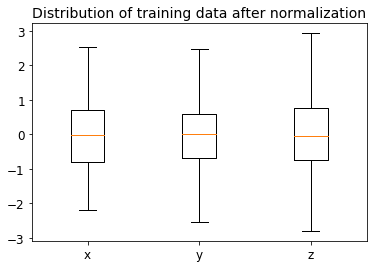

In [97]:
train_X_normalized = Normalize(train_X)
box_plot(train_X_normalized.numpy(), 'Distribution of training data after normalization')

Much better.

__Note:__ The test dataset will also be normalized using the mean and variance of the training dataset.

### 3.2. Setting up a neural network with keras

In [42]:
model_nn = Sequential([
    Input(shape=(3,)),
    Normalize,
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation='sigmoid')])

loss_fn = keras.losses.BinaryCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.001)

model_nn.compile(loss=loss_fn,
                 optimizer='adam',
                 metrics=['accuracy'])

model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

### 3.3. Training and testing

In [43]:
model_nn.fit(train_X, train_y, epochs=10)

Epoch 1/10
248/248 [==============================] - 1s 2ms/step - loss: 0.4357 - accuracy: 0.8015
Epoch 2/10
248/248 [==============================] - 1s 2ms/step - loss: 0.2090 - accuracy: 0.9083
Epoch 3/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1703 - accuracy: 0.9210
Epoch 4/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1416 - accuracy: 0.9356
Epoch 5/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1372 - accuracy: 0.9356
Epoch 6/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1341 - accuracy: 0.9420
Epoch 7/10
248/248 [==============================] - 1s 3ms/step - loss: 0.1160 - accuracy: 0.9486
Epoch 8/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1086 - accuracy: 0.9509
Epoch 9/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9567
Epoch 10/10
248/248 [==============================] - 1s 2ms/step - loss: 0.1061 - accuracy: 0.9556

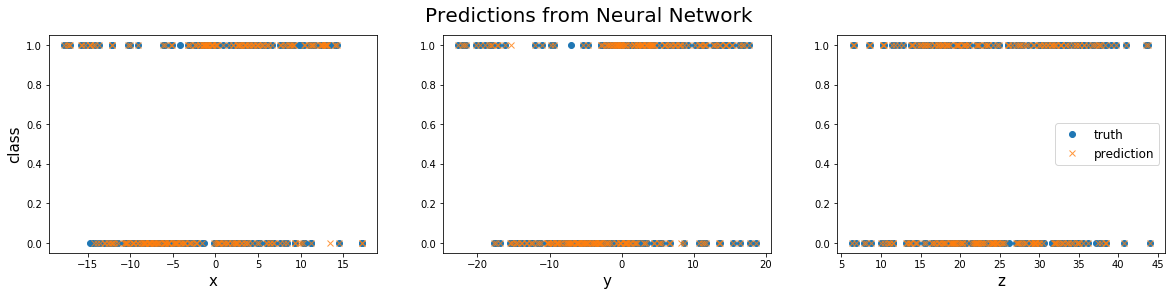

In [44]:
class to_binary():
    def __init__(self, pred_model, cutoff=0.5):
        self.model = pred_model
        self.cutoff = cutoff
    def predict(self, X):
        ypred = self.model(X)
        ypred_binary = np.array([0 if p < self.cutoff else 1 for p in ypred])
        return ypred_binary

model_nn_binary = to_binary(model_nn)
plot_predictions(model_nn_binary.predict, test_X, test_y, 'Predictions from Neural Network')

In [45]:
loss_nn, accuracy_nn = model_nn.evaluate(test_X, test_y)

62/62 [==============================] - 0s 3ms/step - loss: 0.0979 - accuracy: 0.9556


__Tip:__ Experiment with different numbers of hidden layers, units, number of epochs, etc in the neural network and see how it affects the test accuracy. Also observe what happens when you remove the normalization layer from the network. You should see that the performance becomes slightly worse!